## Fix for ScraperAgent Not Defined

If you get `NameError: name 'ScraperAgent' is not defined`, make sure to run the cell below **before** running the main test cell. This will define a minimal ScraperAgent in the notebook scope.

In [7]:
# Minimal ScraperAgent for notebook testing
class ScraperAgent:
    def scrape(self, data):
        return data

## Update Python Libraries (If Needed)

If you're experiencing issues with newer API keys or models, you might need to update the dependencies.

In [8]:
# Uncomment and run this cell if you need to update libraries
# !pip install -U openai langchain langchain-openai

## Load Configuration

Important: Run this cell first to load the configuration file.

In [9]:
import json

# Load configuration from config.json
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print(f"Configuration loaded successfully.")
    print(f"Model: {config.get('model_name', 'Not specified')}")
    api_key = config.get('api_key', '')
    print(f"API key length: {len(api_key)}")
    if len(api_key) > 20:
        print(f"API key starts with: {api_key[:10]}...")
    else:
        print("Warning: API key seems too short or empty.")
except Exception as e:
    print(f"Error loading configuration: {str(e)}")
    # Create a default config to avoid errors
    config = {"model_name": "o3-mini", "api_key": ""}

Configuration loaded successfully.
Model: gpt-4o
API key length: 164
API key starts with: sk-proj-PG...


## Run the Multi-Agent Structure Test

This test uses real sample review data from sample_reviews.py.

In [10]:
import os
# from agents.scraper import ScraperAgent  # Now defined above
from agents.preprocessing import PreprocessingAgent
from agents.analyzer import AnalyzerAgent
from agents.coordinator import CoordinatorAgent
from agents.report import ReportAgent
from agents.gpt_handler import GPTHandler
from data.sample_reviews import SHOPEE_REVIEWS, YOUTUBE_REVIEWS

# Set OpenAI API key environment variable (needed for langchain)
os.environ['OPENAI_API_KEY'] = config.get('api_key', '')

# Verify CoordinatorAgent accepts config parameter
import inspect
coord_params = inspect.signature(CoordinatorAgent.__init__).parameters
if 'config' not in coord_params:
    print("WARNING: CoordinatorAgent doesn't have config parameter. Module reload needed.")
    print("Available parameters:", list(coord_params.keys()))
else:
    print("CoordinatorAgent correctly accepts config parameter")

# Use actual sample review data instead of hardcoded test data
test_reviews = SHOPEE_REVIEWS + YOUTUBE_REVIEWS
print(f"Loaded {len(SHOPEE_REVIEWS)} Shopee reviews and {len(YOUTUBE_REVIEWS)} YouTube reviews")

# Step 1: Scrape (pass-through for sample data)
scraper = ScraperAgent()
scraped = scraper.scrape(test_reviews)
print(f"Scraped {len(scraped)} reviews.")

# Step 2: Preprocess
preprocessor = PreprocessingAgent()
preprocessed = preprocessor.preprocess(scraped)
print(f"Preprocessed {len(preprocessed)} reviews.")

# Display a few examples of preprocessed reviews
for i, review in enumerate(preprocessed[:3]):
    print(f"\nExample {i+1}:")
    if 'review_text' in review:
        print(f"- Text: {review['review_text'][:50]}...")
    elif 'comment' in review:
        print(f"- Comment: {review['comment'][:50]}...")
    print(f"- Platform: {review.get('platform', 'Unknown')}")
    print(f"- Product: {review.get('product_name', 'Unknown')}")

# Step 3: Analyze (single agent test)
analyzer = AnalyzerAgent(config=config)
# Only analyze a few examples to avoid long execution times
analysis_sample = preprocessed[:3]
analysis_results = [analyzer.analyze(r) for r in analysis_sample]
for res in analysis_results:
    print(res)

try:
    # Step 4: Coordinator (should use config)
    coordinator = CoordinatorAgent(config=config)
    product_id = "S001"  # Wireless Earbuds
    print(f"\nAnalyzing reviews for product ID: {product_id} (Wireless Earbuds)")
    product_reviews = [r for r in preprocessed if r["product_id"] == product_id]
    print(f"Found {len(product_reviews)} reviews for this product")
    
    # Use only a small subset to speed up testing
    test_subset = product_reviews[:3]
    print(f"Using a subset of {len(test_subset)} reviews for testing")
    
    summary = coordinator.analyze_product_reviews(test_subset)
    print("Coordinator summary:", summary)
    
    # Step 5: Report Agent
    report_agent = ReportAgent()
    report = report_agent.compile(summary)
    print("\nReport:")
    for key, value in report['products'][0].items():
        if isinstance(value, list) and len(value) > 3:
            print(f"{key}: {value[:3]}...")
        else:
            print(f"{key}: {value}")
    
    # Step 6: GPT Handler
    gpt_handler = GPTHandler(config=config)
    gpt_summary = gpt_handler.generate_summary(report)
    print("\nGPT Summary:", gpt_summary)
    
except Exception as e:
    print(f"Error during execution: {str(e)}")
    print("\nIf this is an authentication error, please check that:")
    print("1. Your API key in config.json is correct and active")
    print("2. You have billing set up in your OpenAI account")
    print("3. The model name in your config.json is available to your account")
    
    import traceback
    traceback.print_exc()

CoordinatorAgent correctly accepts config parameter
Loaded 5 Shopee reviews and 5 YouTube reviews
Scraped 10 reviews.
Preprocessed 10 reviews.

Example 1:
- Text: extremely satisfied with these earbuds! the sound ...
- Platform: Shopee
- Product: Wireless Earbuds

Example 2:
- Text: disappointed with these earbuds. they disconnect f...
- Platform: Shopee
- Product: Wireless Earbuds

Example 3:
- Text: average product. sound quality is okay but not as ...
- Platform: Shopee
- Product: Wireless Earbuds
{'agent': 'AnalyzerAgent', 'sentiment': 'neutral', 'intensity': 'weak', 'key_phrases': ['extremely', 'satisfied', 'these'], 'text': 'extremely satisfied with these earbuds! the sound quality is amazing and battery life is impressive. worth every penny.'}
{'agent': 'AnalyzerAgent', 'sentiment': 'positive', 'intensity': 'moderate', 'key_phrases': ['disappointed', 'these', 'earbuds.'], 'text': 'disappointed with these earbuds. they disconnect frequently and the battery drains too quickly. wou

## Agent Communication Visualization

This cell demonstrates how agents communicate with each other during the analysis process. It shows the flow of information between different specialized agents and how they collaborate to produce a unified result.


--- Agent Communication Test ---
Processing review about Wireless Earbuds
Review text: extremely satisfied with these earbuds! the sound quality is amazing and battery life is impressive. worth every penny.

Communication flow:
1. DetailedAnalyzer processing Wireless Earbuds
2. ContextualAnalyzer processing Wireless Earbuds
3. CoordinatorAgent processing Unknown

Agent Memory Contents:
Insights stored: 1
Analysis records: 1

Sample insight stored in memory:
Final sentiment: unknown
Confidence: 5/10
Key aspects:

Visualizing Agent Communication Graph:


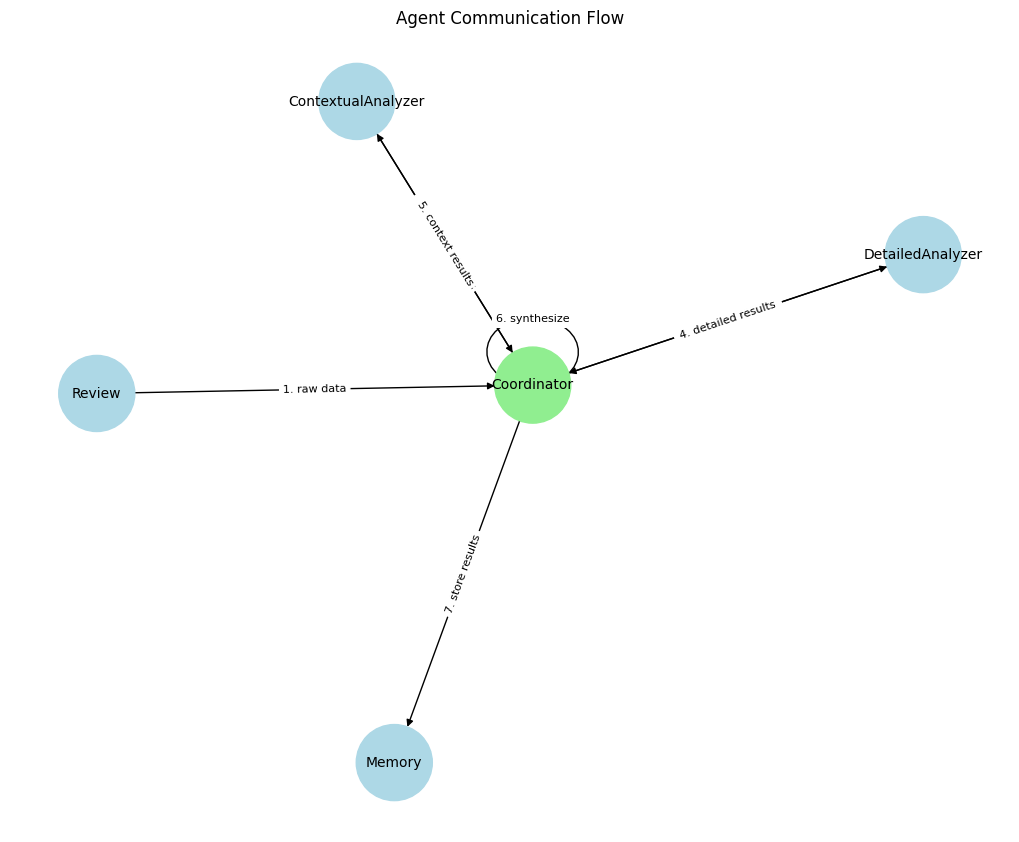


End of agent communication test


In [ ]:
import json
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple tracking decorator to monitor agent communication
communications = []
def track_communication(func):
    def wrapper(*args, **kwargs):
        agent_name = args[0].__class__.__name__
        if len(args) > 1 and hasattr(args[1], 'get') and callable(args[1].get):
            product = args[1].get('product_name', 'Unknown')
            communications.append(f"{agent_name} processing {product}")
        result = func(*args, **kwargs)
        return result
    return wrapper

# Apply tracking to key methods to see communication flow
# Import necessary components
from agents.analyzers import DetailedAnalyzer, ContextualAnalyzer
from agents.memory_utils import EnhancedMemory

# Save original method references
original_detailed_analyze = DetailedAnalyzer.analyze
original_contextual_analyze = ContextualAnalyzer.analyze
original_synthesize = CoordinatorAgent._synthesize_analyses

# Add tracking decorators
DetailedAnalyzer.analyze = track_communication(DetailedAnalyzer.analyze)
ContextualAnalyzer.analyze = track_communication(ContextualAnalyzer.analyze)
CoordinatorAgent._synthesize_analyses = track_communication(CoordinatorAgent._synthesize_analyses)

# Create a simple test to show agent interaction
print("\n--- Agent Communication Test ---")
coordinator = CoordinatorAgent(config=config)
memory = EnhancedMemory()
coordinator.memory = memory

# Process a single review to trace the full communication flow
test_review = preprocessed[0]  # Get the first review from earlier processing
print(f"Processing review about {test_review.get('product_name')}")
print(f"Review text: {test_review.get('review_text', test_review.get('comment', ''))}\n")

# Analyze using coordinator which will trigger communication between agents
result = coordinator.analyze_review(test_review)

# Print the communication trace
print("Communication flow:")
for i, comm in enumerate(communications):
    print(f"{i+1}. {comm}")

# Visualize the agent memory to show how information is stored
print("\nAgent Memory Contents:")
product_id = test_review.get('product_id')
memory_contents = coordinator.memory.get_product_memory(product_id)
print(f"Insights stored: {len(memory_contents['insights'])}")
print(f"Analysis records: {len(memory_contents['sentiment_history'])}")

# Extract just one insight to see inside
if memory_contents['insights']:
    print("\nSample insight stored in memory:")
    insight = memory_contents['insights'][0]
    # Format insight for readability
    print(f"Final sentiment: {insight.get('final_sentiment', 'unknown')}")
    print(f"Confidence: {insight.get('confidence', 0)}/10")
    print(f"Key aspects:")
    for aspect in insight.get('key_aspects', []):
        print(f"  - {aspect.get('aspect', 'unknown')}: {aspect.get('sentiment', 'unknown')}")

# Create a simple graph visualization of agent interaction
print("\nVisualizing Agent Communication Graph:")
G = nx.DiGraph()
G.add_node("Coordinator", role="orchestrator")
G.add_node("DetailedAnalyzer", role="sentiment")
G.add_node("ContextualAnalyzer", role="context")
G.add_node("Memory", role="storage")
G.add_node("Review", role="input")

# Add edges representing communication flow
G.add_edge("Review", "Coordinator", step=1, message="raw data")
G.add_edge("Coordinator", "DetailedAnalyzer", step=2, message="request analysis")
G.add_edge("Coordinator", "ContextualAnalyzer", step=3, message="request analysis")
G.add_edge("DetailedAnalyzer", "Coordinator", step=4, message="detailed results")
G.add_edge("ContextualAnalyzer", "Coordinator", step=5, message="context results")
G.add_edge("Coordinator", "Coordinator", step=6, message="synthesize")
G.add_edge("Coordinator", "Memory", step=7, message="store results")

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
node_colors = ['lightblue' if G.nodes[n]['role'] != 'orchestrator' else 'lightgreen' for n in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=3000, font_size=10)

# Add edge labels
edge_labels = {(u, v): f"{d['step']}. {d['message']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("Agent Communication Flow")
plt.axis('off')
plt.show()

# Restore original methods to avoid affecting other cells
DetailedAnalyzer.analyze = original_detailed_analyze
ContextualAnalyzer.analyze = original_contextual_analyze
CoordinatorAgent._synthesize_analyses = original_synthesize

print("\nEnd of agent communication test")

## Observe Agent Debate

This cell demonstrates how agents debate and reconcile different opinions when analyzing sentiment.

In [12]:
# Create two analyzer agents with different parameters to simulate diverse opinions
analyzer1 = AnalyzerAgent(name="OptimisticAnalyzer")
analyzer2 = AnalyzerAgent(name="CriticalAnalyzer")

# Select a review with mixed sentiment for the debate
mixed_review = None
for review in preprocessed:
    if "average" in review.get('review_text', '').lower() or "okay" in review.get('review_text', '').lower():
        mixed_review = review
        break

if not mixed_review:
    mixed_review = preprocessed[2]  # Fallback to third review

print(f"Analyzing review: {mixed_review.get('review_text', mixed_review.get('comment', ''))}")

# Have agents debate the review
debate_result = analyzer1.debate(analyzer2, mixed_review)

print("\nAgent Debate Results:")
print(f"Agent 1 ({debate_result['agent_1']['agent']}) opinion: {debate_result['agent_1']['sentiment']}")
print(f"Agent 2 ({debate_result['agent_2']['agent']}) opinion: {debate_result['agent_2']['sentiment']}")
print(f"Resolution: {debate_result['resolution']}")

# Show detailed analysis from coordinator for comparison
print("\nCoordinator's Analysis (combining multiple perspectives):")
coordinator_result = coordinator.analyze_review(mixed_review)
print(f"Final sentiment: {coordinator_result.get('final_sentiment')}")
print(f"Confidence: {coordinator_result.get('confidence')}/10")
print(f"Summary: {coordinator_result.get('summary')}")

Analyzing review: average product. sound quality is okay but not as good as advertised. the fit is comfortable though.

Agent Debate Results:
Agent 1 (OptimisticAnalyzer) opinion: neutral
Agent 2 (CriticalAnalyzer) opinion: neutral
Resolution: agreement

Coordinator's Analysis (combining multiple perspectives):
Final sentiment: unknown
Confidence: 5/10
Summary: Could not synthesize analyses properly
